# Week 4 - Partial Least Squares Regression

In [1]:
import scipy as sp, numpy as np
from sklearn.preprocessing import scale, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import LeaveOneGroupOut, LeaveOneOut
import matplotlib.pyplot as plt

data = sp.io.loadmat('wk4_Cosgrove-data.mat', squeeze_me=True)['s']

X = data['X'].item() # the untransformed data matrix (66x102)
Y = data['Y'].item() # the untransformed LDH release at 48hours. (66x1)
phosphoproteins = data['phosphoproteins'].item() # names of phosphoproteins
conditions = data['conditions'].item() # cell array of the 66 conditions
drugList = data['drugList'].item() # description of the drugs used in each of the 66 conditions
drugListToxic = data['drugListToxic'].item() # binary value corresponding to whether drugList[i] is toxic
drugs = data['drugs'].item() # binary matrix mapping which measurements correspond to a drug treatment in drugList
cytokineList = data['cytokineList'].item() # cell array of cytokine treatments
ind4pProtein = data['ind4pProtein'].item() # the column indices corresponding to measurements of the 4 phosphoprotein subset

#### (1) Perform PLSR on the matrixes X and Y. Plot the percent variance explained. How many principal components do you need for each to explain 90% of the variance? Discuss your findings.

Hint: Be sure to normalize each dataset as needed for the analysis.

Based on my plot, I need 4 or more principle components to capture over 90% of the variance in the model, shown by the red dashed line. Only using 3 principle components captures slightly less than 90% of the variance.


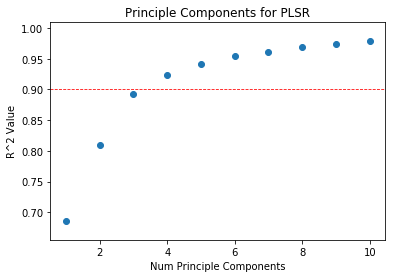

In [2]:
from scipy.stats import zscore

Xnorm = zscore(X)
Y1 = np.squeeze(Y[:, 4:5]) # take 5th column of Y matrix
Ynorm = zscore(Y1)

max_PC = 10
Perc_vari = np.zeros(max_PC)
ArrPC = np.linspace(1, max_PC, num = max_PC, dtype = int)

for i, num_PC in enumerate(ArrPC):
    plsr = PLSRegression(n_components = num_PC)
    plsr.fit(Xnorm, Ynorm)
    Perc_vari[i] = plsr.score(Xnorm, Ynorm)

def plot(X, Y, xlab = None, ylab = None, title = None, plotType = 'scatter', xbound = None, ybound = None, axes = False, size = None, col = None):
    if size is not None:
        plt.figure(figsize = size)
    if plotType == 'scatter':
        plt.scatter(X, Y, color = col)
    elif plotType == 'plot':
        plt.plot(X, Y)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title);
    if axes == True:
        plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth = 0.7); # include line y = 0
        plt.axvline(x = 0, color = 'k', linestyle = '-', linewidth = 0.7); # include line y = 0
    plt.xlim(xbound)
    plt.ylim(ybound)
    
plot(ArrPC, Perc_vari, xlab = 'Num Principle Components', ylab = 'R^2 Value', title = 'Principle Components for PLSR')
plt.axhline(y = 0.9, color = 'r', linestyle = '--', linewidth = 0.8); # include line y = 0.9
print("Based on my plot, I need 4 or more principle components to capture over 90% of the variance in the model, shown by the red dashed line. Only using 3 principle components captures slightly less than 90% of the variance.")

#### (2) Recreate the Figure S2A plot from Cosgrove et al. supplementary information. This is the PLSR scores plot (for PC1 and PC2), with toxic drugs colored according to the drug type and all other drugs are not colored. Use the drugList, drugListToxic to identify these categories.

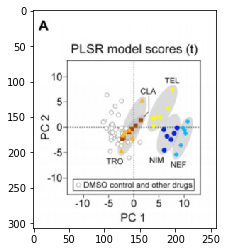

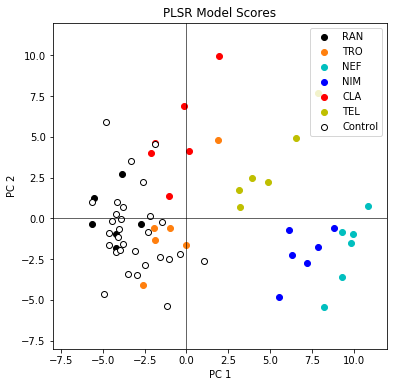

In [3]:
import matplotlib.image as mplimg
def image(img, size = (4,4)):
    im_path = img
    fig = mplimg.imread(im_path)
    plt.figure(figsize = size);
    plt.imshow(fig);
    
image('CosgroveFigS2A.jpg')
#image('CosgroveFigS2Caption.jpg', size = (12,6))

def PLSR_Scores_Loadings(Xplsr = Xnorm, Yplsr = Ynorm, Scores = True, xbound = None, ybound = None): # doesn't work for loadings
    plsr = PLSRegression(n_components = 2)
    plsr.fit(Xplsr, Yplsr)
    if Scores == True:
        PC1x = plsr.x_scores_[:,0:1]
        PC2x = plsr.x_scores_[:,1:2]
    elif Scores == False:
        PC1x = plsr.x_loadings_[:,0:1]
        PC2x = plsr.x_loadings_[:,1:2]  
        PC1y = plsr.y_loadings_[:,0:1]
        PC2y = plsr.y_loadings_[:,1:2]    

    PC1toxic = np.zeros((6, np.sum(drugListToxic)))
    PC2toxic = np.zeros((6, np.sum(drugListToxic)))
    PC1nontoxic = np.zeros(len(drugs) - 6*np.sum(drugListToxic))
    PC2nontoxic = np.zeros(len(drugs) - 6*np.sum(drugListToxic))
    ToxicDrugs = ['' for x in range(np.sum(drugListToxic))]

    # divide PC1 and PC2 into toxic and nontoxic
    toxCount = 0
    nontoxCount = 0
    for idx, Toxic in enumerate(drugListToxic):
        if Toxic == 1: # separate each toxic drug type into arrays
            ToxicDrugs[toxCount] = drugList[idx]
            toxNCount = 0
            for n in range(len(drugs)):
                if drugs[n, idx] == 1:
                    PC1toxic[toxNCount, toxCount] = PC1x[n]
                    PC2toxic[toxNCount, toxCount] = PC2x[n]
                    toxNCount += 1
            toxCount += 1

        else: # drug is not toxic
            for n in range(len(drugs)):
                if drugs[n, idx] == 1:
                    PC1nontoxic[nontoxCount] = PC1x[n]
                    PC2nontoxic[nontoxCount] = PC2x[n]
                    nontoxCount += 1

    # Plot
    plt.figure(figsize=(6,6))
    col = ['k', 'tab:orange', 'c', 'b', 'r', 'y', 'w']
    for i in range(len(ToxicDrugs)):
        plt.scatter(PC1toxic[:, i], PC2toxic[:, i], color = col[i])

    plt.scatter(PC1nontoxic, PC2nontoxic, color = col[6], edgecolors = 'k') # plot nontoxic drugs
    ToxicDrugs.append('Control')
    plt.legend(ToxicDrugs)
    
    plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth = 0.6); # include line y = 0
    plt.axvline(x = 0, color = 'k', linestyle = '-', linewidth = 0.6); # include line x = 0
    plt.xlim(xbound)
    plt.ylim(ybound)

    if Scores == True:
        plt.title('PLSR Model Scores')        
    elif Scores == False:
        plt.title('PLSR Model Loadings')
        plt.scatter(PC1y, PC2y, color = 'green', marker = 's', s = 50) # also plot y loadings
    plt.xlabel('PC 1')
    plt.ylabel('PC 2');

PLSR_Scores_Loadings(xbound = (-8,12), ybound = (-8,12))

#### (3) Create the loadings plot corresponding to (2). Interpret the results shown on the plot.

An increase in PC1 of the scores plot corresponds with increased cell death. NIM, NEF, and TEL are positively located on PC1, indicating their toxicity compared to the DMSO control in white. On the loadings plot, signals located positively on PC1 correspond to drugs with greater toxicity/ drugs positively located on PC1 of the scores plot.


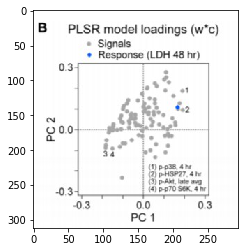

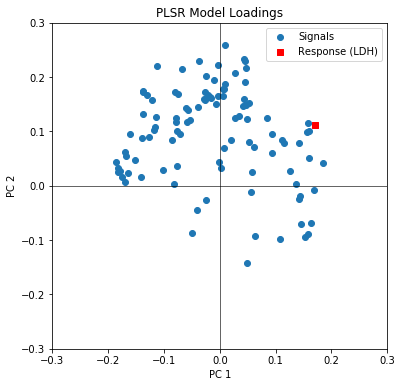

In [11]:
def PLSR_Loadings(Xplsr = Xnorm, Yplsr = Ynorm, xbound = None, ybound = None):
    plsr = PLSRegression(n_components = 2)
    plsr.fit(Xplsr, Yplsr)

    PC1x = plsr.x_loadings_[:,0:1]
    PC2x = plsr.x_loadings_[:,1:2]
    PC1y = plsr.y_loadings_[:,0:1]
    PC2y = plsr.y_loadings_[:,1:2]    

    # Plot
    plt.figure(figsize = (6,6))
    plt.scatter(PC1x, PC2x) # phosphoproteins
    plt.title('PLSR Model Loadings')
    plt.scatter(PC1y, PC2y, color = 'r', marker = 's', s =40) # also plot y loadings
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    leg = ['Signals', 'Response (LDH)']
    plt.legend(leg)
    plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth = 0.6); # include line y = 0
    plt.axvline(x = 0, color = 'k', linestyle = '-', linewidth = 0.6); # include line x = 0
    plt.xlim(xbound)
    plt.ylim(ybound)

image('CosgroveFigS2B.jpg')
PLSR_Loadings(xbound = (-0.3,0.3), ybound = (-0.3,0.3))
print("An increase in PC1 of the scores plot corresponds with increased cell death. NIM, NEF, and TEL are positively located on PC1, indicating their toxicity compared to the DMSO control in white. On the loadings plot, signals located positively on PC1 correspond to drugs with greater toxicity/ drugs positively located on PC1 of the scores plot.")

#### (4) Recreate a 4-principal component model using PLSR with just the final 4 phosphoprotein model. Plot predicted v. observed LDH for this model. Report the model fitness ($R^2$). Define here how you are calculating $R^2$.

R squared = 0.8821899
I calculate my R squared value using the equation from slide 18 of lecture 8. This is based on the sum of squared difference of my predicted and observed LDH. That is, 1 minus (the sum of (the difference in my predicted and observed LDH) squared) over the sum of (the observed LDH) squared.


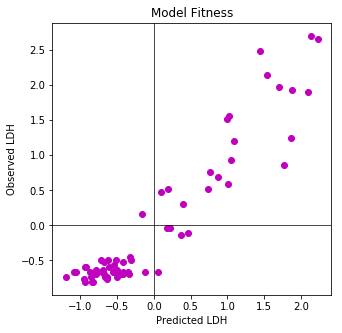

In [12]:
def PLSR_Model(Xnorm, Ynorm):
    # Build PLSR Model based on normalized X and Y data
    plsr4 = PLSRegression(n_components = 4)

    plsr4.fit_transform(Xnorm, Ynorm)
    Ypred = np.squeeze(plsr4.predict(Xnorm))
    return Ypred

def R_squared(Ymod, Yobs):
    # Calculate R^2 based on difference between predicted and observed Y values
    R_2 = 1 - np.sum((Ymod-Yobs)**2)/np.sum(Yobs**2)
    print('R squared = %.7f' % R_2)    

X4p = zscore(X[:, ind4pProtein])

Ypred = PLSR_Model(X4p, Ynorm)
R_squared(Ypred, Ynorm)
plot(Ypred, Ynorm, xlab = 'Predicted LDH', ylab = 'Observed LDH', title = 'Model Fitness', axes = True, size = (5,5), col = 'm')
print("I calculate my R squared value using the equation from slide 18 of lecture 8. This is based on the sum of squared difference of my predicted and observed LDH. That is, 1 minus (the sum of (the difference in my predicted and observed LDH) squared) over the sum of (the observed LDH) squared.")

#### (6) Cosgrove *et al* discusses their method for model validation using leave-one-out cross-validation. Calculate all LDH predictions for leave-one-out cross-validation and calculate the R^2 value for the resulting yfit values. What is the R^2 value? Why do you think it’s important to perform cross-validation?

R squared = 0.8200461
It is important to perform cross validation because it tests the model fitness. It is the only way to get 'new' data to use your model on. If cross validation performs well, then the model is good. In this case, since we want to make predictions, cross validation is critical to asses our model strength.


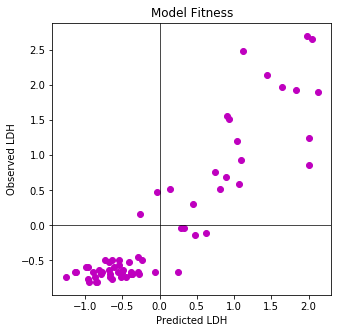

In [13]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

YpredictLOO = np.zeros(len(X4p))

for train, test in loo.split(X4p):

    X4pTrain = zscore(X4p[train]) # get normalized X training set
    YnormTrain = zscore(Ynorm[train]) # get normalized Y training set

    plsr4 = PLSRegression(n_components = 4) # set up 4 component PLSR
    plsr4.fit_transform(X4pTrain, YnormTrain) # build model based on normalized training sets

    sclr_tst = np.asscalar(test)
    YpredictLOO[sclr_tst] = np.asscalar(np.matmul(X4p[sclr_tst], plsr4.coef_)) # multiply test set by model coefficients from training set to get Y predicted for test index
R_squared(YpredictLOO, Ynorm) # get R^2
plot(YpredictLOO, Ynorm, xlab = 'Predicted LDH', ylab = 'Observed LDH', title = 'Model Fitness', axes = True, size = (5,5), col = 'm')
print("It is important to perform cross validation because it tests the model fitness. It is the only way to get 'new' data to use your model on. If cross validation performs well, then the model is good. In this case, since we want to make predictions, cross validation is critical to asses our model strength.")

#### (7) Now, instead of performing LOOCV, let's perform leave-one-cytokine-out cross-validation. That is, one cytokine at a time, leave out all the data for the `NoCyt`, `IL-1`, `LPS`, `TNF`, `IL-6`, or `Mix` conditions.

Hint: Look at `sklearn.model_selection.LeaveOneGroupOut`.

How does this affect your cross-validation? How do the two approaches here differ? When might each be most appropriate?

R squared = 0.7984933
My R squared value decreases slightly using cross validation across the cytokines. Leaving out cytokine groups tests how good the model is at predicting the outcome of new cytokines while leaving out drug-cytokine combinations tests the model strength at predicting new drug-cytokine combinations.
Given that the R squared value decreases slightly for cytokines, the model is slightly worse at predicting new cytokines than drug-cytokine combinations.


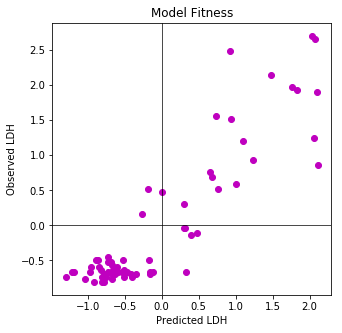

In [14]:
'''from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()'''
cytokines = data['cytokines'].item() # cell array of cytokine treatments

idxTrain = np.zeros(55)
idxTest = np.zeros(11)

YpredictLOO = np.zeros(len(X4p))
for i in range(len(cytokineList)):
    countTrain = 0
    countTest = 0
    for n in range(len(cytokines)): # separate test and train data
        if cytokines[n, i] != 1: # put in training data set
            idxTrain[countTrain] = n
            countTrain += 1
        else: # put in test data set
            idxTest[countTest] = n
            countTest += 1

    idxTrain = idxTrain.astype(int)
    idxTest = idxTest.astype(int)

    X4pTrain = zscore(X4p[idxTrain])
    X4pTest = X4p[idxTest]
    YnormTrain = zscore(Ynorm[idxTrain])
    
    plsr4 = PLSRegression(n_components = 4) # set up 4 component PLSR
    plsr4.fit_transform(X4pTrain, YnormTrain) # build model based on normalized training sets

    YpredictLOO[idxTest] = np.squeeze(np.matmul(X4pTest, plsr4.coef_)) # multiply test set by model coefficients from training set to get Y predicted for test index
R_squared(YpredictLOO, Ynorm) # get R^2# build model based on train data.
plot(YpredictLOO, Ynorm, xlab = 'Predicted LDH', ylab = 'Observed LDH', title = 'Model Fitness', axes = True, size = (5,5), col = 'm')
print('My R squared value decreases slightly using cross validation across the cytokines. Leaving out cytokine groups tests how good the model is at predicting the outcome of new cytokines while leaving out drug-cytokine combinations tests the model strength at predicting new drug-cytokine combinations.')
print('Given that the R squared value decreases slightly for cytokines, the model is slightly worse at predicting new cytokines than drug-cytokine combinations.')